# Extract measures and beat

In [39]:
import pickle as pkl
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks
from IPython.display import Audio
from scipy.ndimage import gaussian_filter1d
from typing import Callable

with open("beat_data.pkl","rb") as f:
    data = pkl.load(f)

display(data.keys())

# Loads file audio and BeatNet data, slices into measures, processes and then returns
def get_measures(file: str, process: Callable, ext="mp3"):
    y, sr = librosa.load(f'inputs/{file}.{ext}')

    y_proc = process(y, sr)

    # Truncate to each measure
    beat_data = data[file]
    downbeats = beat_data[beat_data[:,1] == 1, 0]
    downbeat_frames = (downbeats * sr).astype(int)
    raw_measures = []
    proc_measures = []
    for i in range(0, downbeat_frames.shape[0] - 1):
        raw_measures.append(y[downbeat_frames[i]:downbeat_frames[i+1]])
        proc_measures.append(y_proc[downbeat_frames[i]:downbeat_frames[i+1]])

    return raw_measures, proc_measures, sr





# Beat finding functions

def max_pool(x, k):
    x = np.append(x, np.zeros(x.shape[0]//k * k + k - x.shape[0]))
    return x.reshape(-1, k).max(axis=1)

def beat_stdev(m, sr):
    bf = 1. * (m > np.mean(m) + 2 * np.std(m))
    k = int(sr * 0.05)
    bf = max_pool(bf, k)
    # Get the frame indices (rescale up)
    return np.arange(bf.shape[0])[bf == 1] * k

def beat_peaks(m, sr):
    return find_peaks(m, height=np.mean(m) + 2 * np.std(m), distance=int(sr*0.05), prominence=np.std(m))[0]



# Some processing functions
def smooth_power(y, sr):
    power_db = y**2
    return savgol_filter(power_db, sr*0.01, delta=1/sr, polyorder=2, deriv=0,mode='constant')

def log_smooth_power(y, sr):
    power_db = y**2
    return np.log10(.0001 + savgol_filter(power_db, sr*0.01, delta=1/sr, polyorder=2, deriv=0,mode='constant'))


# Testing functions
def do_test(file: str, process: Callable, beat_find: Callable, mstart = None, mend = None, ext="mp3"):

    raw_measures, proc_measures, sr = get_measures(file, process, ext)

    if mstart != None and mend == None:
        mend = mstart
    if mstart == None:
        mstart = 0
        if mend == None:
            mend = len(raw_measures) - 1
    
    raw = np.zeros(0)
    proc = np.zeros(0)
    beat_frames = np.zeros(0)
    clicks = np.zeros(0)
    for i in range(mstart, mend+1):
        m_beat_frames = beat_find(proc_measures[i], sr)
        m_clicks = librosa.clicks(times=m_beat_frames/sr, length=raw_measures[i].shape[0], sr=sr)
        
        # Add to running arrays
        beat_frames = np.append(beat_frames, m_beat_frames + raw.shape[0])
        raw = np.append(raw, raw_measures[i])
        proc = np.append(proc, proc_measures[i])
        clicks = np.append(clicks, m_clicks)


    plt.figure(figsize=(20, 5))
    plt.plot(raw)
    plt.plot(proc)
    plt.scatter(beat_frames, np.zeros(beat_frames.shape), marker='o', color='red', zorder=10)
    display(Audio(data=raw, rate=sr))
    display(Audio(data=raw + clicks, rate=sr))

dict_keys(['fengs', 'lms', '100bpm', 'milaklaw', '06 Encore A', "09 D'Angelo - Spanish Joint", '03 All the Pretty Girls'])

# Some tests

Syntax: do_test(name of file without extension, one of the "processing" functions above, one of the "beat finding" functions above, starting measure, ending measure, extension if not mp3)

If both start measure and end measure omitted, defaults to entire song
If start measure specified but end measure omitted, only does that one measure

In the following test, we have two measures with identical beats.  The first measure I'd say is correct.  The second picks up a few strays.

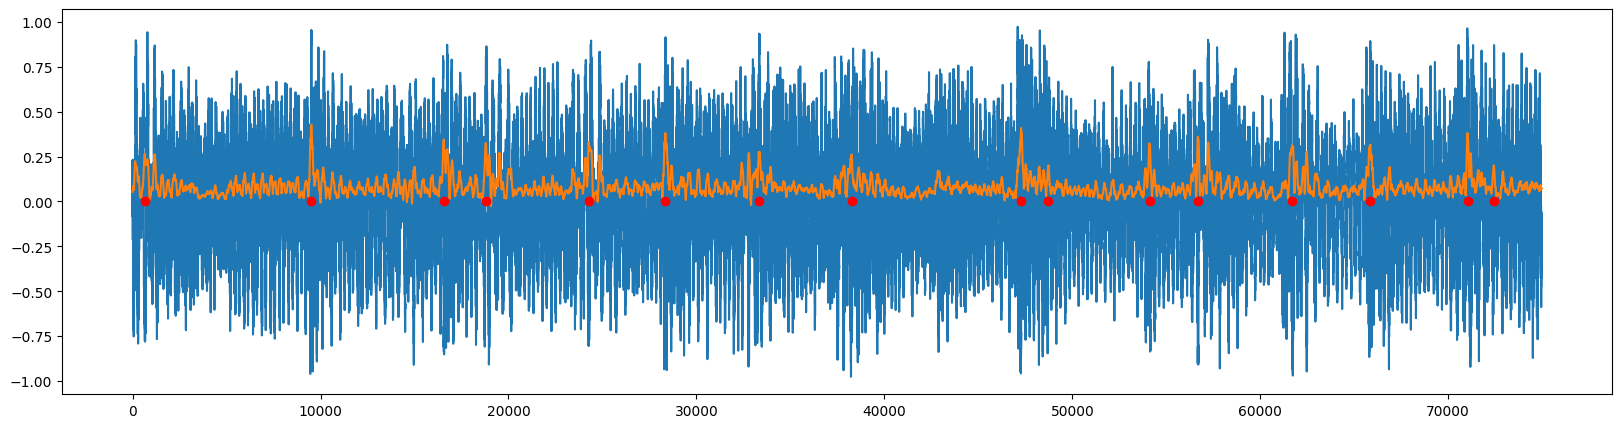

In [40]:
do_test('milaklaw', smooth_power, beat_peaks, 25, 26)

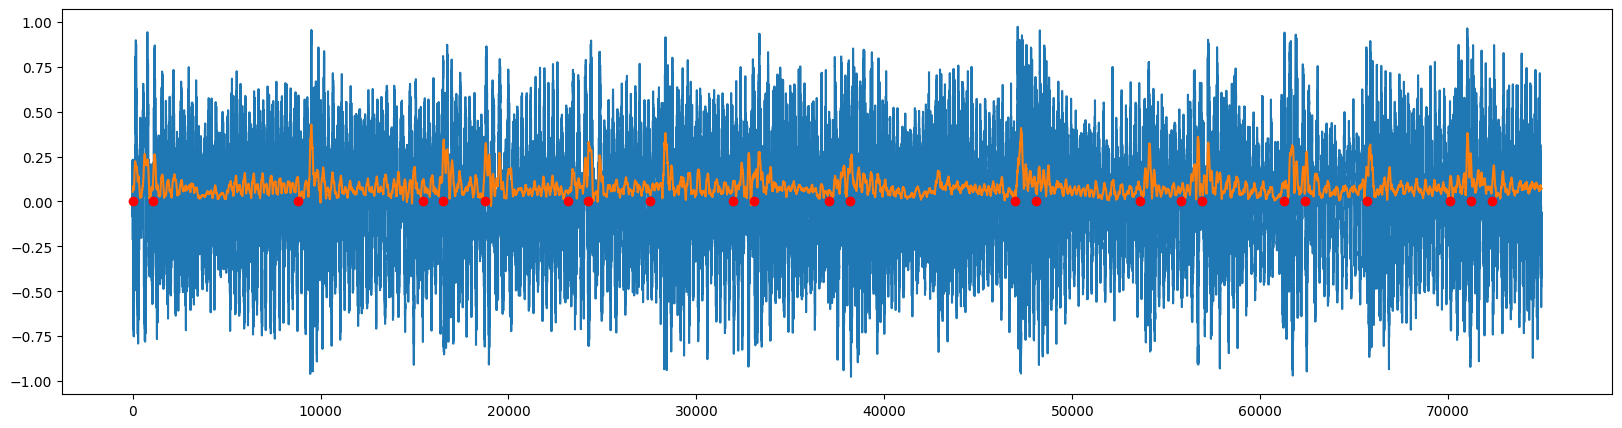

In [41]:
do_test('milaklaw', smooth_power, beat_stdev, 25, 26)

file = 'lms'
i = 22

Here, there's a constant bass drumbeat in the background that doesn't really get picked up, also maybe some multiple clicks

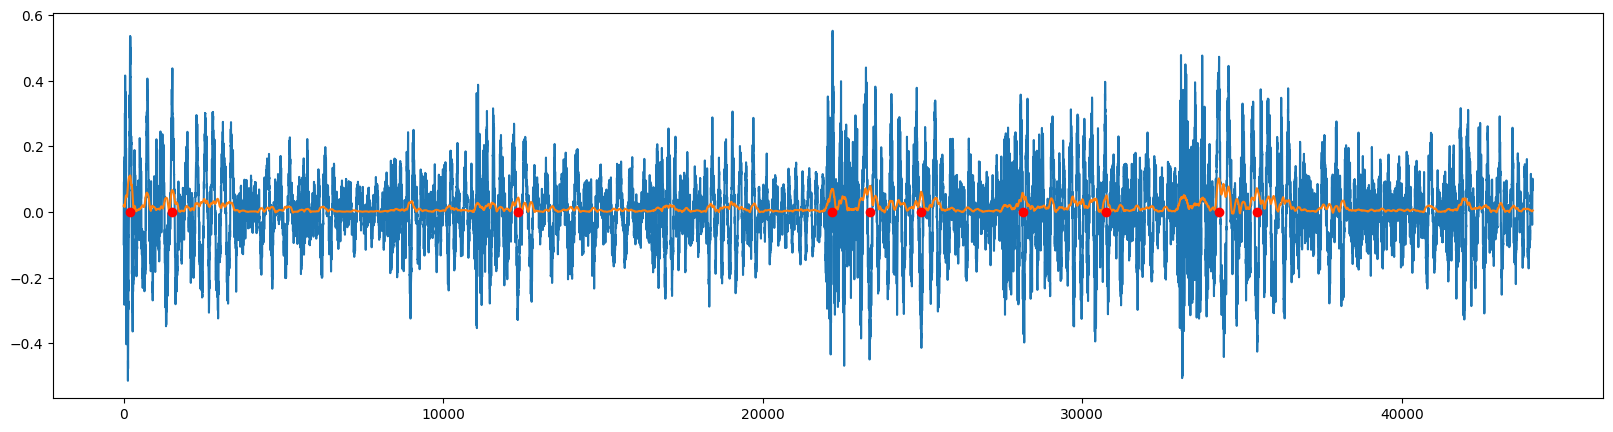

In [42]:
do_test('lms', smooth_power, beat_peaks, 22)


[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


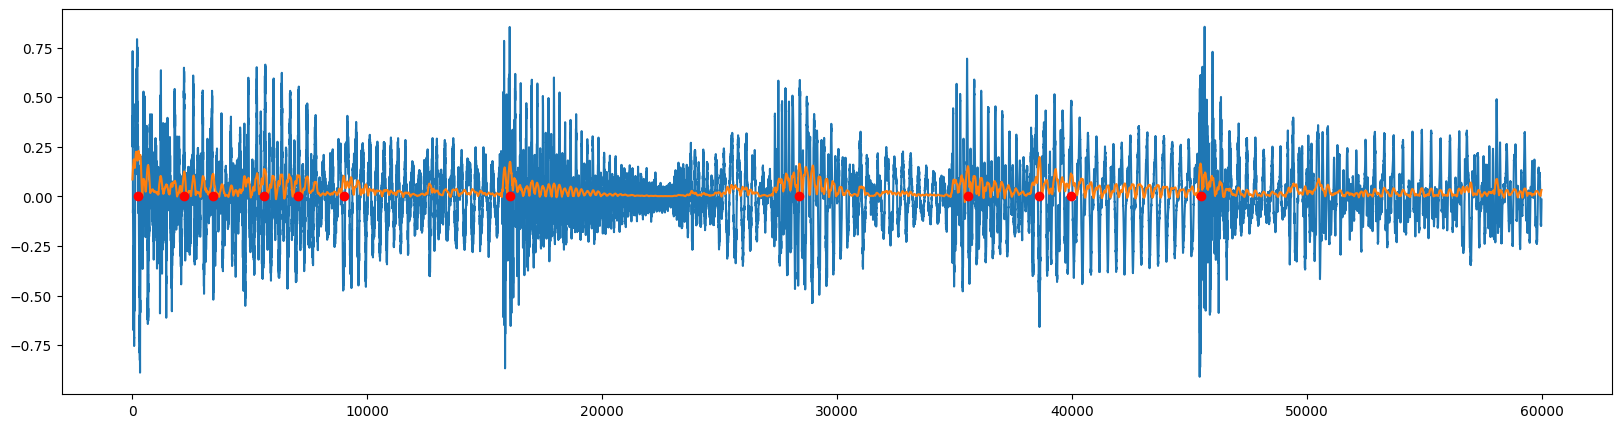

In [43]:
do_test('06 Encore A', smooth_power, beat_peaks, 20)

/tmp/ipykernel_834913/284572037.py:17: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(f'inputs/{file}.{ext}')
/home/harrison/erdos/groove_gang/beatnet/venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


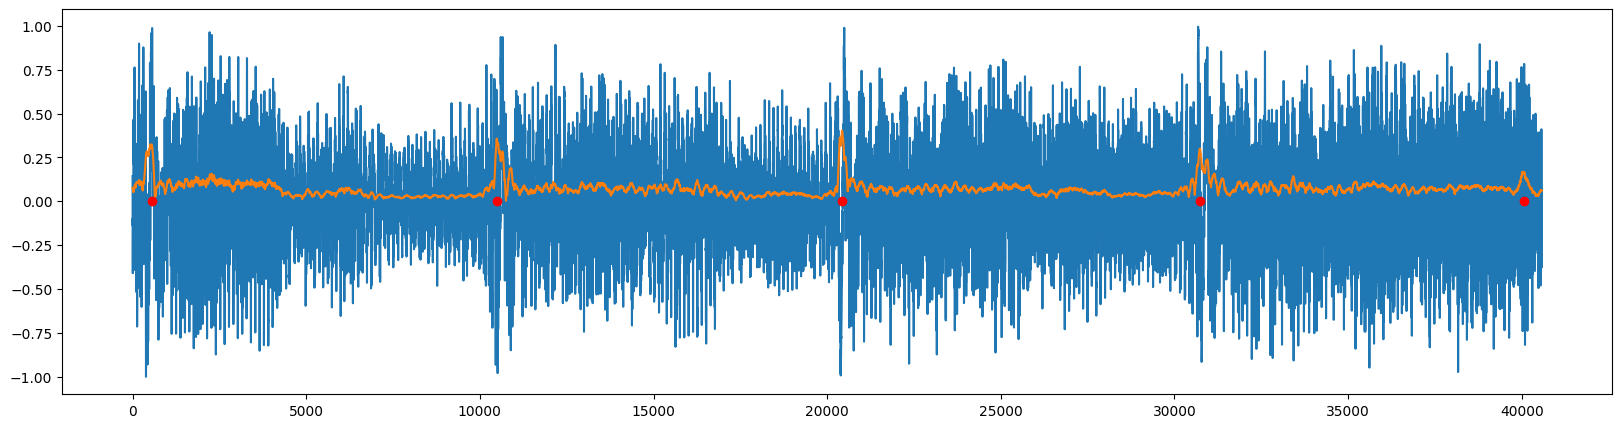

In [44]:
do_test('03 All the Pretty Girls', smooth_power, beat_peaks, 25, ext='m4a')

This one doesn't work so well, I think because a lot of the hits are close to each other and some are a bit soft.

/tmp/ipykernel_834913/284572037.py:17: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(f'inputs/{file}.{ext}')
/home/harrison/erdos/groove_gang/beatnet/venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


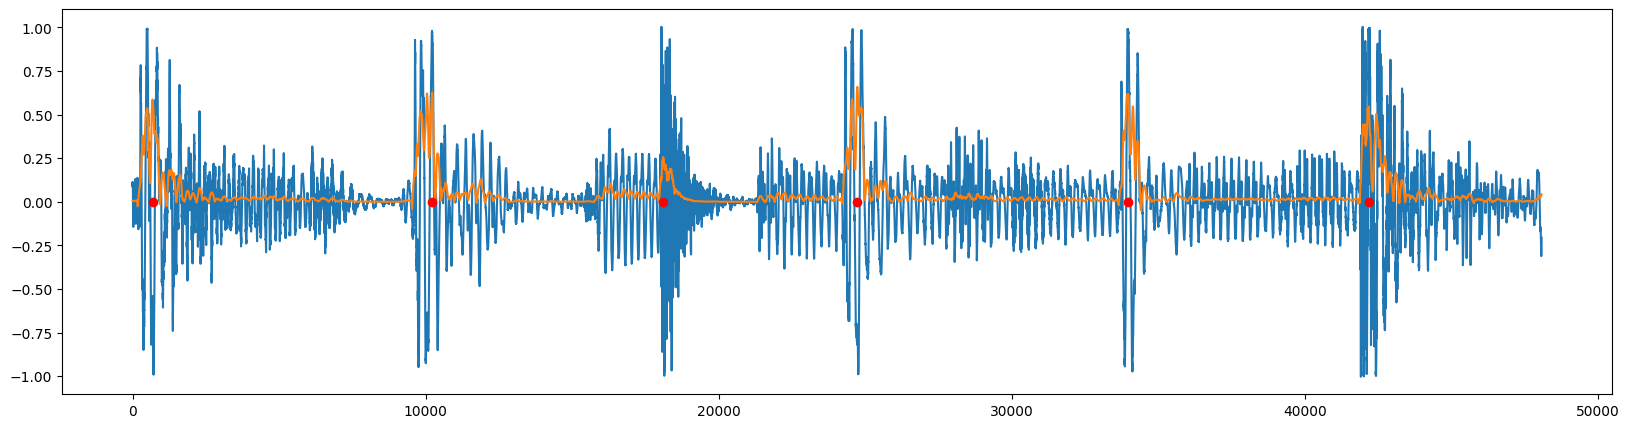

In [45]:
do_test('09 D\'Angelo - Spanish Joint', smooth_power, beat_peaks, 25, ext='m4a')

Try whole song

In [47]:
#do_test('milaklaw', smooth_power, beat_peaks)